# X-Means from Scratch

Clustering algorithms from scratch, namely K-means, K-means++ and DP-means. Create a class to hold these properties/functions in an object oriented design. Looks to be working as well as K-means from sklearn package. For K-means there are visualizations of comparisons to sklearn, and DP-means has visualizations for varying lambda. Clustering algorithms good for pattern detection as well as dimensionality reduction by grouping similar items or data points within fields.

In [1]:
#packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Matplotlib is building the font cache using fc-list. This may take a moment.


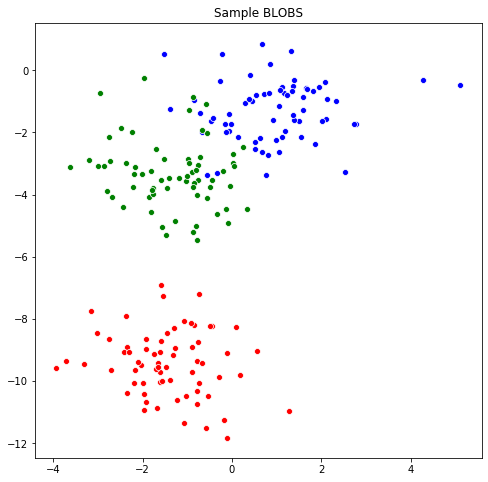

In [2]:
#need to generate data.
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples = 200, centers = 3, n_features = 2, random_state = 2)
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.scatterplot(X[y == 0, 0], X[y == 0, 1], color = 'r')
sns.scatterplot(X[y == 1, 0], X[y == 1, 1], color = 'b')
sns.scatterplot(X[y == 2, 0], X[y == 2, 1], color = 'g')
ax.set(title = 'Sample BLOBS')
plt.show()

In [52]:
#create a class to hold all the clustering functions
class Cluster:
    def __init__(self, x, method, k = None, lamb = None):
        import numpy as np
        
        #error handling
        if len(x[0]) != 2:
            raise TypeError("Data needs to be of dimension N x 2")
        if isinstance(x, np.ndarray) == False:
            raise TypeError("Data needs to be numpy array")
        if not method in ["dp", "k", "k+"]:
            raise TypeError("Method not found")
        if method != "dp" and k == None:
            raise TypeError("Need to specify number of clusters")
        if method == "dp" and lamb == None:
            raise("Need to specify lambda distance threshold")
        
        #k means
        if method == "k":
            mu_x1 = np.random.uniform(min(x[:,0]),max(x[:,0]),k)
            mu_x2 = np.random.uniform(min(x[:,1]),max(x[:,1]),k)
            centers = np.transpose(np.array([mu_x1,mu_x2]))
            clusts_old = np.repeat(1, len(x))
            clusts_new = np.repeat(2, len(x))
        
        if method == "k+":
            mu = np.empty((k,2), dtype = float)
            for i in np.arange(0,k,1):
                if i == 0:
                    loc = round(np.random.uniform(0,len(x)))
                    mu[i] = x[loc,:]
                else:
                    rho = list()
                    for l in np.arange(0,len(x),1):
                        dist = []
                        for c in np.arange(0,i,1):
                            dist.append((np.linalg.norm(x[l,:] - mu[c]))**2)
                        rho.append(min(dist))
                    probs = rho/sum(rho)
                    loc = np.random.choice(np.arange(0,len(x),1), 1, p = probs)
                    mu[i] = x[loc,:]
            centers = np.stack(mu, axis = 0)
            clusts_old = np.repeat(1, len(x))
            clusts_new = np.repeat(2, len(x))
        
        if method in ["k", "k+"]:
            while sum(clusts_new - clusts_old) != 0:
                clusts_old = clusts_new.copy()
                for i in np.arange(0,len(x),1):
                    dist = []
                    for c in np.arange(0,k,1):
                        d = (np.linalg.norm(x[i,:] - centers[c,:]))**2
                        dist.append(d)
                    clusts_new[i] = dist.index(min(dist))
                for c in np.arange(0,k,1):
                    centers[c,0] = np.mean(x[clusts_new == c, 0])
                    centers[c,1] = np.mean(x[clusts_new == c, 1])
            self.clusters = clusts_new
        
        if method == "dp":
            self.k = 1
            mu = np.array([float(np.mean(x[:,0])), float(np.mean(x[:,1]))])
            clusts_old = np.repeat(-1, len(x))
            clusts = np.repeat(0, len(x))
            while sum(clusts - clusts_old) != 0:
                clusts_old = clusts.copy()
                for i in np.arange(0,len(x),1):
                    dist = []
                    for j in np.arange(0,self.k,1):
                        dist.append((np.linalg.norm(x[i,:] - mu[j]))**2)
                    if min(dist) > lamb:
                        self.k+=1
                        clusts[i] = self.k-1 #account for indexing from 0
                        mu = np.vstack((mu, x[i,:])) 
                    else:
                        clusts[i] = dist.index(min(dist))
                for c in np.arange(0,self.k,1):
                    mu[c,0] = np.mean(x[clusts == c, 0])
                    mu[c,1] = np.mean(x[clusts == c, 1])
            self.clusters = clusts
    
    def clust(self):
        return self.clusters

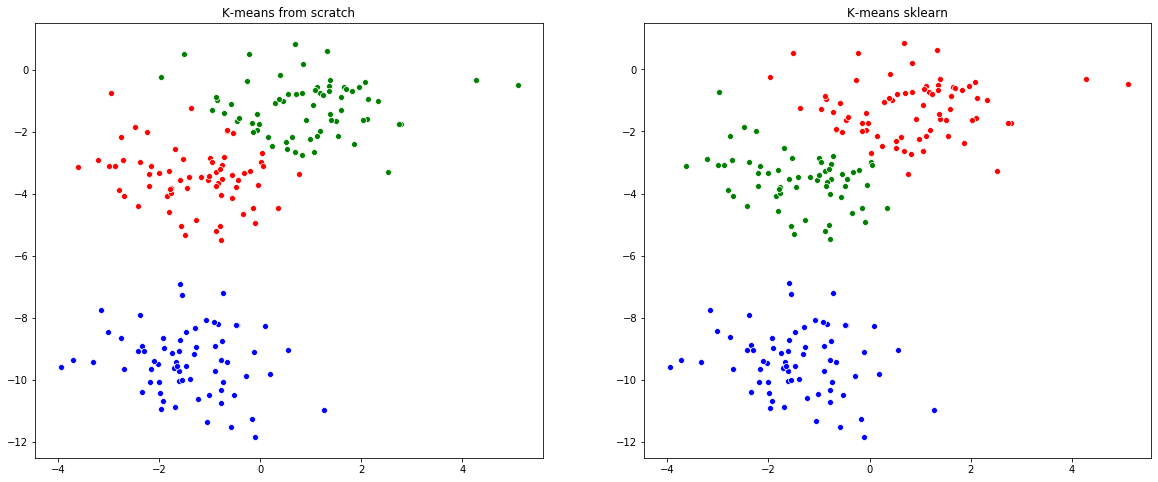

In [64]:
#k-means appears to be working well. colors will change due to randomness, but clusters being identified.
#looks to be the very similar result from sklearn. the true data above shows overlap, so my code and sklearn are
#tripping up at the same spots. difference are likely due to random initalization
#import kmeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,init='random').fit(X)

preds = Cluster(X, method = "k", k = 3).clust()

fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.scatterplot(X[preds == 0, 0], X[preds == 0, 1], ax=ax[0], color = 'r')
sns.scatterplot(X[preds == 1, 0], X[preds == 1, 1], ax=ax[0], color = 'g')
sns.scatterplot(X[preds == 2, 0], X[preds == 2, 1], ax=ax[0], color = 'b')
ax[0].set(title = ('K-means from scratch'))
sns.scatterplot(X[km.labels_ == 0, 0], X[km.labels_ == 0, 1], ax=ax[1], color = 'r')
sns.scatterplot(X[km.labels_ == 1, 0], X[km.labels_ == 1, 1], ax=ax[1], color = 'g')
sns.scatterplot(X[km.labels_ == 2, 0], X[km.labels_ == 2, 1], ax=ax[1], color = 'b')
ax[1].set(title = 'K-means sklearn')
plt.show()

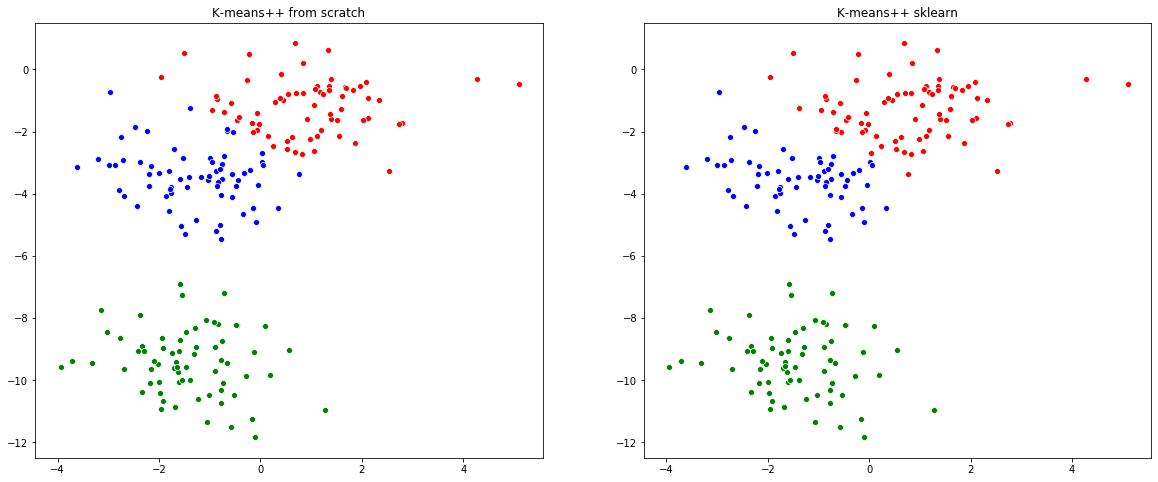

In [66]:
#now for k means++. the only difference is this provides a way to choose the initial centers rather than randomly
#once those centers are chosen, the algorithm is the same as k-means
#colors being same are a coincidence
kmp = KMeans(n_clusters=3,init='k-means++').fit(X)

preds_p = Cluster(X, method = "k+", k = 3).clust()

fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.scatterplot(X[preds_p == 0, 0], X[preds_p == 0, 1], ax=ax[0], color = 'r')
sns.scatterplot(X[preds_p == 1, 0], X[preds_p == 1, 1], ax=ax[0], color = 'g')
sns.scatterplot(X[preds_p == 2, 0], X[preds_p == 2, 1], ax=ax[0], color = 'b')
ax[0].set(title = ('K-means++ from scratch'))
sns.scatterplot(X[kmp.labels_ == 0, 0], X[kmp.labels_ == 0, 1], ax=ax[1], color = 'r')
sns.scatterplot(X[kmp.labels_ == 1, 0], X[kmp.labels_ == 1, 1], ax=ax[1], color = 'g')
sns.scatterplot(X[kmp.labels_ == 2, 0], X[kmp.labels_ == 2, 1], ax=ax[1], color = 'b')
ax[1].set(title = 'K-means++ sklearn')
plt.show()

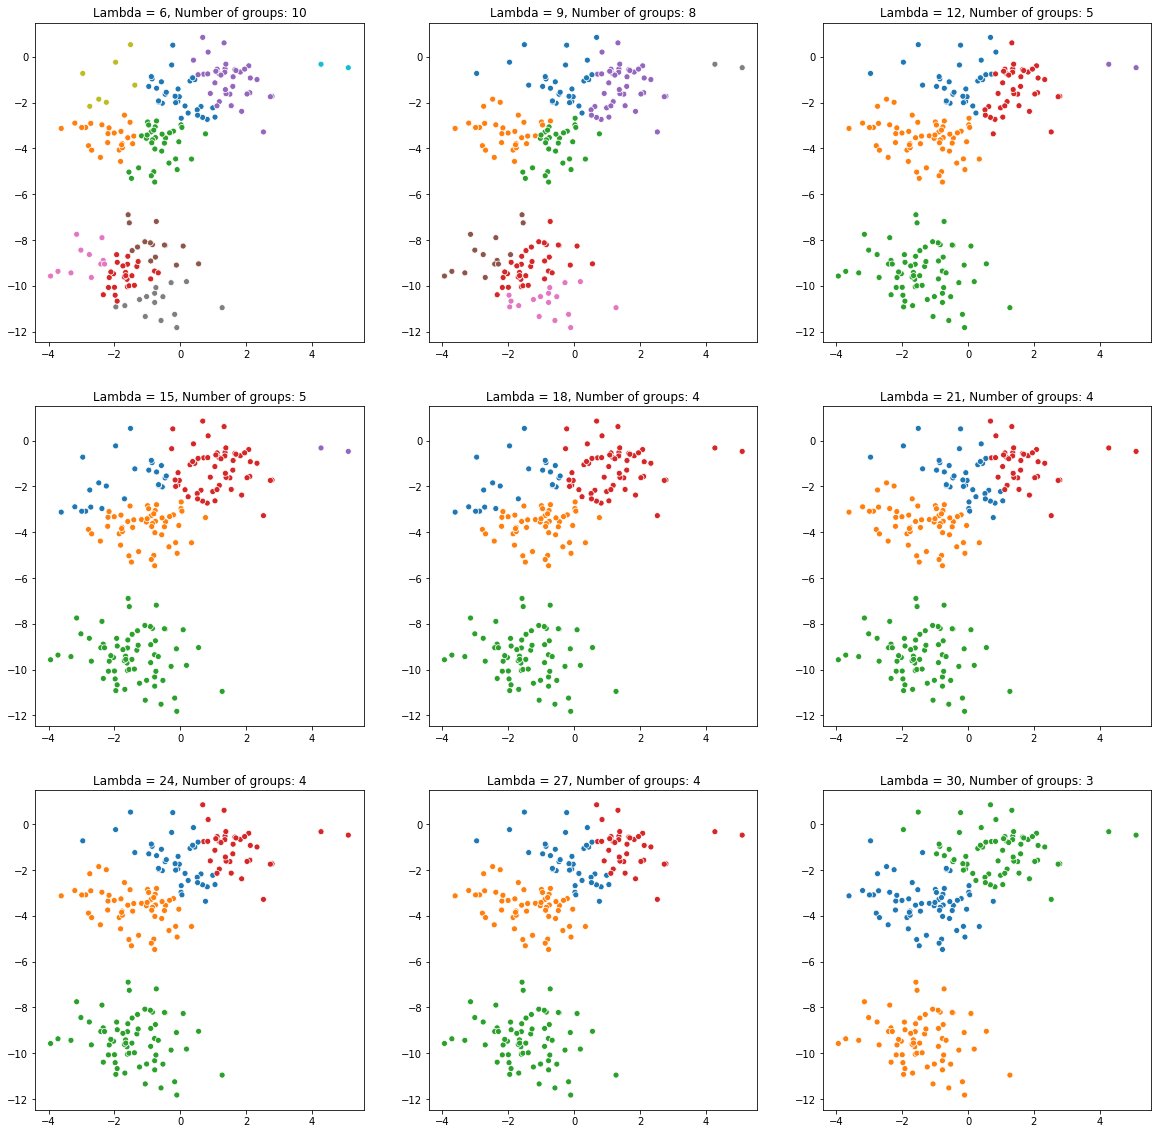

In [67]:
#now try DP-means, which is a variation that does not assume the number of clusters, as this is often not known
#slight variations and usage of EM algorithm to get here, but mostly follows standard k-means
#now there is a tuning parameter lambda to control tradeoff between number of clusters and within group distance

#vary lambda to see how it treats the clustering. larger lambda is closer to k-means, smaller lambda is more groups
#range of data goes roughly from -4 to 4 and 0 to -12 so 12x9 grid
#seaborn misinterprets the labels and thinks they should be on a spectrum. it does not accept converting to string.
#need to use bit of a workaround with a dictionary

#vary lambda
lamb = np.arange(6,33,3)

#color dictionary. doesnt matter what labels are as long as they aren't numeric
colors = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j',10:'k',11:'l',12:'m',13:'n',14:'o',15:'p'}

fig, ax = plt.subplots(3,3,figsize=(20,20))
ax_count = 0
ax = ax.flatten()
for i in lamb:
    labels = Cluster(X, method = "dp", lamb = i).clust()
    color = np.vectorize(colors.get)(labels)
    sns.scatterplot(X[:,0], X[:,1], ax=ax[ax_count], hue = color, legend = False)
    ax[ax_count].set(title = 'Lambda = {0}, Number of groups: {1}'.format(i, len(np.unique(labels))))
    ax_count+=1